In [1]:
import sys
import copy
import random
import os
from typing import Tuple
from collections import OrderedDict

import numpy as np
import PIL 
import matplotlib.pyplot as plt

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# import tensorflow as tf

import torch
from torch import nn, optim
from torch.utils import data
from torchvision import datasets, transforms

In [2]:
# sys.path.append("/home/matthias/Documents/EmbeddedAI/deep-microcompression/")
sys.path.append("../../")

from development.models.utils import convert_from_sequential_torch_to_dmc

from development import (
    Sequential,
    AvgPool2d,
    BatchNorm2d,
    Conv2d,
    Flatten,
    Linear,
    ReLU6,

    EarlyStopper,

    QuantizationGranularity,
    QuantizationScheme
)

/home/matthias/Documents/EmbeddedAI/deep-microcompression/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

input_shape = (3, 32, 32)
LUCKY_NUMBER = 25
torch.manual_seed(LUCKY_NUMBER)
torch.random.manual_seed(LUCKY_NUMBER)
torch.cuda.manual_seed(LUCKY_NUMBER)

DEVICE

'cuda'

## Getting the Datasets

In [4]:
data_transform = transforms.Compose([
    # transforms.RandomCrop((24, 24)),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761)
    )
])


cifar100_train_dataset = datasets.CIFAR100("../../../Datasets/CIFAR_100/", train=True, download=True, transform=data_transform)
cifar100_test_dataset = datasets.CIFAR100("../../../Datasets/CIFAR_100/", train=False, download=True, transform=data_transform)

cifar100_train_loader = data.DataLoader(cifar100_train_dataset, batch_size=256, shuffle=True, num_workers=os.cpu_count())
cifar100_test_loader = data.DataLoader(cifar100_test_dataset, batch_size=256, shuffle=False, num_workers=os.cpu_count())

top1_acc_fun = lambda y_pred, y_true: ((y_pred).argmax(dim=1) == y_true).sum().item()*100
top5_acc_fun = lambda y_pred, y_true: (y_pred.topk(5, dim=1).indices == y_true.unsqueeze(1)).any(dim=1).sum().item()*100

metrics = {
    "top1acc": top1_acc_fun,
    "top5acc" : top5_acc_fun
}

In [5]:
pretraind_vqq_13_torch = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg13_bn", pretrained=True)
vgg_13_torch_model = pretraind_vqq_13_torch.features + nn.Sequential(nn.Flatten()) + pretraind_vqq_13_torch.classifier
vgg_13_dmc_model = convert_from_sequential_torch_to_dmc(vgg_13_torch_model).to(DEVICE)


Using cache found in /home/matthias/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


## Original Model

In [6]:
vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics=metrics, device=DEVICE)

100%|██████████| 40/40 [00:08<00:00,  4.91it/s]


{'top1acc': 74.63, 'top5acc': 91.09}

In [7]:
# vgg_13_dmc_model = vgg_13_dmc_model.fuse()

# evaluate_result = vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics=metrics, device=DEVICE)
# original_size = vgg_13_dmc_model.get_size_in_bytes()
# print(f"The original model accuracy is top1acc = {evaluate_result["top1acc"]:.2f}%  top5acc = {evaluate_result["top5acc"]:.2f}% with size {original_size} bytes.")



In [8]:
# fused_vgg_13_dmc_model = vgg_13_dmc_model.fuse().to(DEVICE)

# evaluate_result = fused_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics=metrics, device=DEVICE)
# original_size = fused_vgg_13_dmc_model.get_size_in_bytes()
# print(f"The fused model accuracy is top1acc = {evaluate_result["top1acc"]:.2f}%  top5acc = {evaluate_result["top5acc"]:.2f}% with size {original_size} bytes.")


In [ ]:
# fused_vgg_13_dmc_model = vgg_13_dmc_model.fuse().to(DEVICE)

# evaluate_result = fused_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics=metrics, device=DEVICE)
# original_size = fused_vgg_13_dmc_model.get_size_in_bytes()
# print(f"The original model accuracy is {evaluate_result["acc"]*100:.2f}% with size {original_size} bytes.")

# # fused_vgg_13_dmc_model.convert_to_c(var_name="vgg_13_dmc_model", src_dir="./Arduino Nano 33 BLE/src/", include_dir="./Arduino Nano 33 BLE/include/")
# fused_vgg_13_dmc_model.convert_to_c(input_shape=input_shape, var_name="vgg_13_dmc_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")

# print(fused_vgg_13_dmc_model.test(device=DEVICE, var_name="vgg_13_dmc_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"))
# # print(fused_vgg_13_dmc_model(vgg_13_dmc_model.test_input[0].unsqueeze(dim=0).detach().clone()))
# evaluate_result["acc"], original_size

In [ ]:
early_stopper = EarlyStopper(
    metric_name="validation_loss",
    min_valid_diff=1e-4,
    mode="min",
    patience=2,
    restore_best_state_dict=True,
)

criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(vgg_13_dmc_model.parameters(), lr=1.e-3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)

sensitivity = vgg_13_dmc_model.get_layers_prune_channel_sensity(
    input_shape=input_shape, data_loader=cifar100_test_loader, metrics=metrics, device=DEVICE,
    train=True,
    train_dataloader=cifar100_train_loader, epochs=2, criterion_fun=criterion_fun, optimizer_fun=optimizion_fun,
    lr_scheduler=lr_scheduler, 
)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
sensitivity["top5acc"].items(), 
sensitivity["top1acc"].items()

dict_items([('conv2d_0', [(0.0, 74.63), (0.0, 91.09), (0.015625, 74.63), (0.015625, 91.09), (0.03125, 74.62), (0.03125, 91.08), (0.046875, 74.62), (0.046875, 91.08), (0.0625, 74.62), (0.0625, 91.08), (0.078125, 74.61), (0.078125, 91.09), (0.09375, 74.64), (0.09375, 91.05), (0.109375, 74.51), (0.109375, 91.02), (0.125, 74.51), (0.125, 91.02), (0.140625, 74.52), (0.140625, 91.0), (0.15625, 74.52), (0.15625, 90.98), (0.171875, 74.34), (0.171875, 90.95), (0.1875, 74.36), (0.1875, 90.94), (0.203125, 74.35), (0.203125, 90.96), (0.21875, 74.35), (0.21875, 90.92), (0.234375, 74.32), (0.234375, 90.96), (0.25, 74.38), (0.25, 90.92), (0.265625, 74.4), (0.265625, 90.94), (0.28125, 74.13), (0.28125, 90.84), (0.296875, 74.09), (0.296875, 90.89), (0.3125, 73.97), (0.3125, 90.99), (0.328125, 73.94), (0.328125, 90.88), (0.34375, 73.78), (0.34375, 90.65), (0.359375, 73.75), (0.359375, 90.65), (0.375, 72.94), (0.375, 90.32), (0.390625, 72.96), (0.390625, 90.29), (0.40625, 72.72), (0.40625, 90.17), (0.421

In [81]:
vgg_13_dmc_model

Sequential(
  (conv2d_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2d_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_0): ReLU(inplace=True)
  (conv2d_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2d_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU(inplace=True)
  (maxpool2d_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2d_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU(inplace=True)
  (conv2d_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2d_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_3): ReLU(inplace=True)
  (maxpool2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_4): Conv2d(128

In [86]:
torch.save(sensitivity, "vgg13_top1 and top5 acc.pk")

In [11]:
sensitivity = torch.load("vgg13_top1 and top5 acc_withoutsaving.pk")
sensitivity

{'top1acc': {'conv2d_0': [(0.0, 74.63),
   (0.0, 91.09),
   (0.015625, 74.63),
   (0.015625, 91.09),
   (0.03125, 74.62),
   (0.03125, 91.08),
   (0.046875, 74.62),
   (0.046875, 91.08),
   (0.0625, 74.62),
   (0.0625, 91.08),
   (0.078125, 74.61),
   (0.078125, 91.09),
   (0.09375, 74.64),
   (0.09375, 91.05),
   (0.109375, 74.51),
   (0.109375, 91.02),
   (0.125, 74.51),
   (0.125, 91.02),
   (0.140625, 74.52),
   (0.140625, 91.0),
   (0.15625, 74.52),
   (0.15625, 90.98),
   (0.171875, 74.34),
   (0.171875, 90.95),
   (0.1875, 74.36),
   (0.1875, 90.94),
   (0.203125, 74.35),
   (0.203125, 90.96),
   (0.21875, 74.35),
   (0.21875, 90.92),
   (0.234375, 74.32),
   (0.234375, 90.96),
   (0.25, 74.38),
   (0.25, 90.92),
   (0.265625, 74.4),
   (0.265625, 90.94),
   (0.28125, 74.13),
   (0.28125, 90.84),
   (0.296875, 74.09),
   (0.296875, 90.89),
   (0.3125, 73.97),
   (0.3125, 90.99),
   (0.328125, 73.94),
   (0.328125, 90.88),
   (0.34375, 73.78),
   (0.34375, 90.65),
   (0.359375, 7

In [27]:
list(sensitivity["top5acc"].values())[0]

[(0.0, 74.63),
 (0.0, 91.09),
 (0.015625, 74.63),
 (0.015625, 91.09),
 (0.03125, 74.62),
 (0.03125, 91.08),
 (0.046875, 74.62),
 (0.046875, 91.08),
 (0.0625, 74.62),
 (0.0625, 91.08),
 (0.078125, 74.61),
 (0.078125, 91.09),
 (0.09375, 74.64),
 (0.09375, 91.05),
 (0.109375, 74.51),
 (0.109375, 91.02),
 (0.125, 74.51),
 (0.125, 91.02),
 (0.140625, 74.52),
 (0.140625, 91.0),
 (0.15625, 74.52),
 (0.15625, 90.98),
 (0.171875, 74.34),
 (0.171875, 90.95),
 (0.1875, 74.36),
 (0.1875, 90.94),
 (0.203125, 74.35),
 (0.203125, 90.96),
 (0.21875, 74.35),
 (0.21875, 90.92),
 (0.234375, 74.32),
 (0.234375, 90.96),
 (0.25, 74.38),
 (0.25, 90.92),
 (0.265625, 74.4),
 (0.265625, 90.94),
 (0.28125, 74.13),
 (0.28125, 90.84),
 (0.296875, 74.09),
 (0.296875, 90.89),
 (0.3125, 73.97),
 (0.3125, 90.99),
 (0.328125, 73.94),
 (0.328125, 90.88),
 (0.34375, 73.78),
 (0.34375, 90.65),
 (0.359375, 73.75),
 (0.359375, 90.65),
 (0.375, 72.94),
 (0.375, 90.32),
 (0.390625, 72.96),
 (0.390625, 90.29),
 (0.40625, 72.72

In [29]:
list(zip(*list(sensitivity["top1acc"].values())[0]))

[(0.0,
  0.0,
  0.015625,
  0.015625,
  0.03125,
  0.03125,
  0.046875,
  0.046875,
  0.0625,
  0.0625,
  0.078125,
  0.078125,
  0.09375,
  0.09375,
  0.109375,
  0.109375,
  0.125,
  0.125,
  0.140625,
  0.140625,
  0.15625,
  0.15625,
  0.171875,
  0.171875,
  0.1875,
  0.1875,
  0.203125,
  0.203125,
  0.21875,
  0.21875,
  0.234375,
  0.234375,
  0.25,
  0.25,
  0.265625,
  0.265625,
  0.28125,
  0.28125,
  0.296875,
  0.296875,
  0.3125,
  0.3125,
  0.328125,
  0.328125,
  0.34375,
  0.34375,
  0.359375,
  0.359375,
  0.375,
  0.375,
  0.390625,
  0.390625,
  0.40625,
  0.40625,
  0.421875,
  0.421875,
  0.4375,
  0.4375,
  0.453125,
  0.453125,
  0.46875,
  0.46875,
  0.484375,
  0.484375,
  0.5,
  0.5,
  0.515625,
  0.515625,
  0.53125,
  0.53125,
  0.546875,
  0.546875,
  0.5625,
  0.5625,
  0.578125,
  0.578125,
  0.59375,
  0.59375,
  0.609375,
  0.609375,
  0.625,
  0.625,
  0.640625,
  0.640625,
  0.65625,
  0.65625,
  0.671875,
  0.671875,
  0.6875,
  0.6875,
  0.703125,


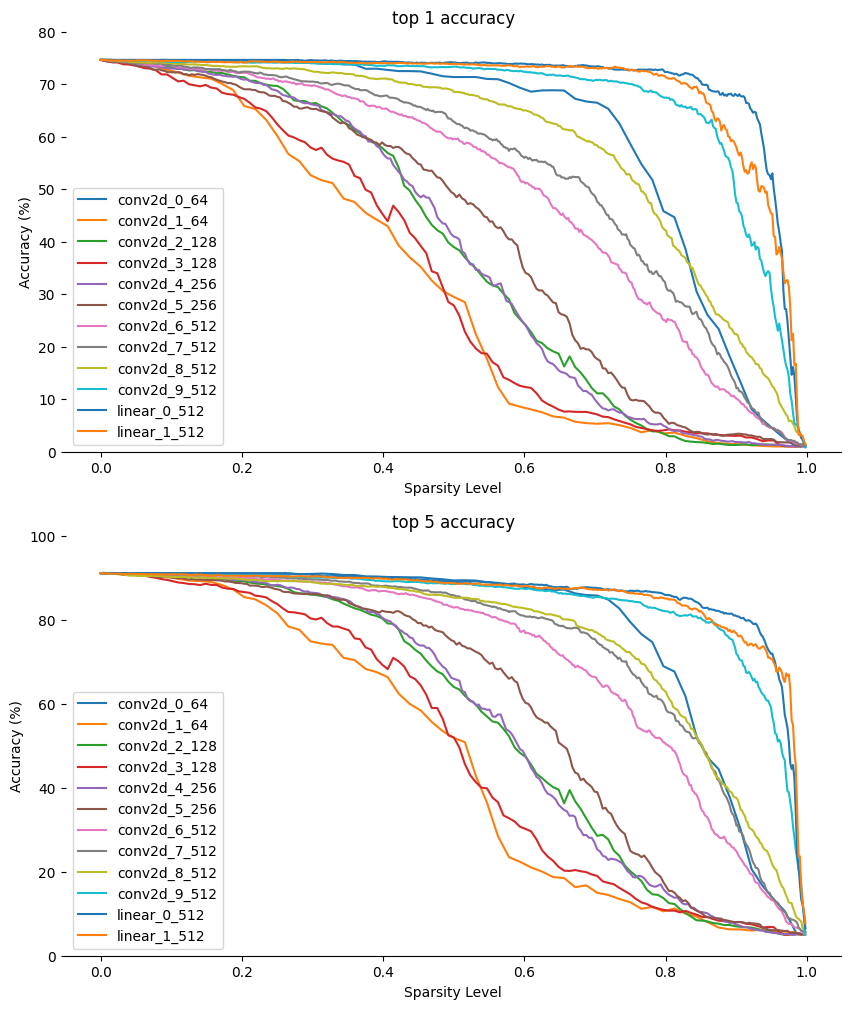

In [38]:
fig, axes = plt.subplots(2, figsize=(10, 12))
start = 1
y_lmin = [80, 100]
for start, top in zip([0, 1], [1, 5]):
    for layer, values in sensitivity[f'top{5}acc'].items():
        sparsity, acc = list(zip(*values))
        axes[start].plot(sparsity[start::2], acc[start::2], label=layer+f"_{str(len(values)//2)}")
        # break

    axes[start].set_xlabel("Sparsity Level")
    axes[start].set_ylabel("Accuracy (%)")
    axes[start].set_title(f"top {top} accuracy")
    axes[start].set_ylim(0, y_lmin[start])
    axes[start].legend()
    axes[start].grid(False)

    list(axes[start].spines.values())[0].set_visible(False)
    list(axes[start].spines.values())[1].set_visible(False)
    list(axes[start].spines.values())[3].set_visible(False)

# fig.suptitle("VGG-13 Sparsity Sensitivity per Layer")

# plt.savefig("VGG-13 Sparsity Sensitivity per Layer", dpi=300, bbox_inches="tight")
# plt.figure(figsize=(10, 6))
# for layer, values in sensitivity['top1acc'].items():
#     print(len(values), values)
#     sparsity, acc = zip(*values)
#     plt.plot(sparsity, acc, marker='.', label=layer+f"_{str(len(values))}")

# plt.xlabel("Sparsity Level")
# plt.ylabel("Accuracy (%)")
# plt.title("Lenet-5 model Sparsity Sensitivity per Layer")
# plt.legend()
# plt.grid(False)

# list(plt.gca().spines.values())[0].set_visible(False)
# list(plt.gca().spines.values())[1].set_visible(False)
# list(plt.gca().spines.values())[3].set_visible(False)

# plt.savefig("Lenet-5 model Sparsity Sensitivity per Layer", dpi=300, bbox_inches="tight")
# plt.show()



## Testing Compression on VGG13

## Pruning

In [ ]:
for i in range(0, 11, 1):
    sp = i/10
    compression_config = {
        "prune_channel" :{
            "sparsity" : sp,
            "metric" : "l2"
        },
    }
    compressed_vgg_13_dmc_model = vgg_13_dmc_model.init_compress(compression_config, input_shape=input_shape)

    evaluate_result = compressed_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics, device=DEVICE)
    size = compressed_vgg_13_dmc_model.get_size_in_bytes()
    print(f"Before training, sparsity = {sp} acc1 = {evaluate_result["top1acc"]:.2f}% acc5 = {evaluate_result["top5acc"]:.2f}% size = {size/original_size*100:9.4f}")


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Before training, sparsity = 0.0 acc1 = 74.63% acc5 = 91.09% size =  100.0000


100%|██████████| 40/40 [00:43<00:00,  1.08s/it]


Before training, sparsity = 0.1 acc1 = 44.80% acc5 = 65.40% size =   81.2115


100%|██████████| 40/40 [00:46<00:00,  1.16s/it]


Before training, sparsity = 0.2 acc1 = 16.97% acc5 = 34.68% size =   64.2513


100%|██████████| 40/40 [00:41<00:00,  1.05s/it]


Before training, sparsity = 0.3 acc1 = 4.07% acc5 = 12.53% size =   49.3318


100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


Before training, sparsity = 0.4 acc1 = 1.24% acc5 = 6.56% size =   36.3321


100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Before training, sparsity = 0.5 acc1 = 1.20% acc5 = 4.97% size =   25.1433


100%|██████████| 40/40 [00:38<00:00,  1.03it/s]


Before training, sparsity = 0.6 acc1 = 1.00% acc5 = 5.04% size =   16.2091


100%|██████████| 40/40 [00:38<00:00,  1.03it/s]


Before training, sparsity = 0.7 acc1 = 1.00% acc5 = 5.00% size =    9.1811


100%|██████████| 40/40 [00:37<00:00,  1.06it/s]


Before training, sparsity = 0.8 acc1 = 1.00% acc5 = 5.00% size =    4.1533


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Before training, sparsity = 0.9 acc1 = 1.00% acc5 = 5.00% size =    1.0858


100%|██████████| 40/40 [00:36<00:00,  1.11it/s]


Before training, sparsity = 1.0 acc1 = 1.00% acc5 = 5.00% size =    0.0032


### Dynamic Quantization Per Tensor

In [ ]:
for b in [8, 4, 2]:
    compression_config = {
        "quantize" : {
            "scheme" : QuantizationScheme.DYNAMIC,
            "granularity": QuantizationGranularity.PER_TENSOR,
            "bitwidth" : b
        }
    }
    compressed_vgg_13_dmc_model = vgg_13_dmc_model.init_compress(compression_config, input_shape=input_shape)

    evaluate_result = compressed_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics, device=DEVICE)
    size = compressed_vgg_13_dmc_model.get_size_in_bytes()
    print(f"Before training, sparsity = {sp} acc1 = {evaluate_result["top1acc"]:.2f}% acc5 = {evaluate_result["top5acc"]:.2f}% size = {size/original_size*100:9.4f}")


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


Before training, sparsity = 1.0 acc1 = 74.43% acc5 = 90.94% size =   25.0307


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


Before training, sparsity = 1.0 acc1 = 45.30% acc5 = 67.25% size =   12.5358


100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


Before training, sparsity = 1.0 acc1 = 1.00% acc5 = 5.00% size =    6.2883


### Dynamic Quantization Per Channel

In [ ]:
for b in [8, 4, 2]:
    compression_config = {
        "quantize" : {
            "scheme" : QuantizationScheme.DYNAMIC,
            "granularity": QuantizationGranularity.PER_CHANNEL,
            "bitwidth" : b
        }
    }
    compressed_vgg_13_dmc_model = vgg_13_dmc_model.init_compress(compression_config, input_shape=input_shape)

    evaluate_result = compressed_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics, device=DEVICE)
    size = compressed_vgg_13_dmc_model.get_size_in_bytes()
    print(f"Before training, sparsity = {sp} acc1 = {evaluate_result["top1acc"]:.2f}% acc5 = {evaluate_result["top5acc"]:.2f}% size = {size/original_size*100:9.4f}")


100%|██████████| 40/40 [00:38<00:00,  1.05it/s]


Before training, sparsity = 1.0 acc1 = 74.66% acc5 = 91.06% size =   25.0713


100%|██████████| 40/40 [00:37<00:00,  1.07it/s]


Before training, sparsity = 1.0 acc1 = 72.38% acc5 = 90.03% size =   12.5764


100%|██████████| 40/40 [00:37<00:00,  1.06it/s]


Before training, sparsity = 1.0 acc1 = 1.00% acc5 = 5.09% size =    6.3290


### Static Quantization Per Tensor

In [ ]:
for b in [8, 4, 2]:
    compression_config = {
        "quantize" : {
            "scheme" : QuantizationScheme.STATIC,
            "granularity": QuantizationGranularity.PER_TENSOR,
            "bitwidth" : b
        }
    }
    compressed_vgg_13_dmc_model = vgg_13_dmc_model.init_compress(compression_config, input_shape=input_shape, calibration_data=next(iter(cifar100_test_loader))[0])

    evaluate_result = compressed_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics, device=DEVICE)
    size = compressed_vgg_13_dmc_model.get_size_in_bytes()
    print(f"Before training, sparsity = {sp} acc1 = {evaluate_result["top1acc"]:.2f}% acc5 = {evaluate_result["top5acc"]:.2f}% size = {size/original_size*100:9.4f}")


100%|██████████| 40/40 [01:02<00:00,  1.57s/it]


Before training, sparsity = 1.0 acc1 = 74.28% acc5 = 90.90% size =   25.0309


100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


Before training, sparsity = 1.0 acc1 = 27.19% acc5 = 44.92% size =   12.5360


100%|██████████| 40/40 [00:57<00:00,  1.43s/it]


Before training, sparsity = 1.0 acc1 = 1.00% acc5 = 5.00% size =    6.2885


### Static Quantization Per Channel

In [ ]:
for b in [8, 4, 2]:
    compression_config = {
        "quantize" : {
            "scheme" : QuantizationScheme.STATIC,
            "granularity": QuantizationGranularity.PER_CHANNEL,
            "bitwidth" : b
        }
    }
    compressed_vgg_13_dmc_model = vgg_13_dmc_model.init_compress(compression_config, input_shape=input_shape,calibration_data=next(iter(cifar100_test_loader))[0])

    evaluate_result = compressed_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics, device=DEVICE)
    size = compressed_vgg_13_dmc_model.get_size_in_bytes()
    print(f"Before training, sparsity = {sp} acc1 = {evaluate_result["top1acc"]:.2f}% acc5 = {evaluate_result["top5acc"]:.2f}% size = {size/original_size*100:9.4f}")


100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


Before training, sparsity = 1.0 acc1 = 74.64% acc5 = 91.12% size =   25.0715


100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


Before training, sparsity = 1.0 acc1 = 59.75% acc5 = 78.69% size =   12.5766


100%|██████████| 40/40 [00:52<00:00,  1.32s/it]


Before training, sparsity = 1.0 acc1 = 1.09% acc5 = 5.13% size =    6.3292


## Training with Compression

### Pruning

In [ ]:
sp = 1/10
compression_config = {
    "prune_channel" :{
        "sparsity" : sp,
        "metric" : "l2"
    },
}
compressed_vgg_13_dmc_model = vgg_13_dmc_model.init_compress(compression_config, input_shape=input_shape)

evaluate_result = compressed_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics, device=DEVICE)
size = compressed_vgg_13_dmc_model.get_size_in_bytes()
print(f"Before training, sparsity = {sp} acc1 = {evaluate_result["top1acc"]:.2f}% acc5 = {evaluate_result["top5acc"]:.2f}% size = {size/original_size*100:9.4f}")

criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(compressed_vgg_13_dmc_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=3)

early_stopper = EarlyStopper(
    metric_name="validation_loss",
    min_valid_diff=1e-5,
    mode="min",
    patience=7,
    restore_best_state_dict=True,
)

compressed_vgg_13_dmc_model.fit(
    cifar100_train_loader, 
    52000,
    criterion_fun, optimizion_fun, lr_scheduler,
    validation_dataloader=cifar100_test_loader,
    metrics=metrics,
    verbose=True, 
    callbacks=[early_stopper]
)

evaluate_result = compressed_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics, device=DEVICE)
print(f"After training, sparsity = {sp} acc1 = {evaluate_result["top1acc"]:.2f}% acc5 = {evaluate_result["top5acc"]:.2f}% size = {size/original_size*100:9.4f}")


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


Before training, sparsity = 0.1 acc1 = 44.80% acc5 = 65.40% size =   81.2115


  0%|          | 1/52000 [10:30<9108:12:31, 630.58s/it]

epoch    0 | train loss 0.0004 | validation loss 0.0052 | train top1acc 97.4200 | validation top1acc 70.8700 | train top5acc 99.6200 | validation top5acc 89.0100


  0%|          | 2/52000 [20:52<9036:56:09, 625.66s/it]

epoch    1 | train loss 0.0001 | validation loss 0.0052 | train top1acc 99.7360 | validation top1acc 71.3800 | train top5acc 99.9960 | validation top5acc 89.1800


  0%|          | 3/52000 [31:17<9028:23:35, 625.08s/it]

epoch    2 | train loss 0.0000 | validation loss 0.0052 | train top1acc 99.9360 | validation top1acc 71.6200 | train top5acc 100.0000 | validation top5acc 89.3700


  0%|          | 4/52000 [41:26<8936:27:57, 618.73s/it]

epoch    3 | train loss 0.0000 | validation loss 0.0053 | train top1acc 99.9720 | validation top1acc 71.7800 | train top5acc 100.0000 | validation top5acc 89.5400


  0%|          | 5/52000 [51:28<8851:36:18, 612.86s/it]

epoch    4 | train loss 0.0000 | validation loss 0.0053 | train top1acc 99.9680 | validation top1acc 71.7100 | train top5acc 100.0000 | validation top5acc 89.6000


  0%|          | 6/52000 [1:01:49<8891:17:47, 615.62s/it]

epoch    5 | train loss 0.0000 | validation loss 0.0053 | train top1acc 99.9760 | validation top1acc 71.7300 | train top5acc 100.0000 | validation top5acc 89.5800


  0%|          | 7/52000 [1:12:08<8906:30:55, 616.69s/it]

epoch    6 | train loss 0.0000 | validation loss 0.0053 | train top1acc 99.9780 | validation top1acc 71.7700 | train top5acc 100.0000 | validation top5acc 89.5900


  0%|          | 7/52000 [1:22:17<10186:52:03, 705.34s/it]


epoch    7 | train loss 0.0000 | validation loss 0.0053 | train top1acc 99.9780 | validation top1acc 71.6800 | train top5acc 100.0000 | validation top5acc 89.6000
Stopping Training of Sequential with at 0 epoch with best validation_loss = 0.005220910534262657


100%|██████████| 40/40 [00:38<00:00,  1.03it/s]

After training, sparsity = 0.1 acc1 = 71.68% acc5 = 89.60% size =   81.2115


In [ ]:
sp = 3/10
compression_config = {
    "prune_channel" :{
        "sparsity" : sp,
        "metric" : "l2"
    },
}
compressed_vgg_13_dmc_model = vgg_13_dmc_model.init_compress(compression_config, input_shape=input_shape)

evaluate_result = compressed_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics, device=DEVICE)
size = compressed_vgg_13_dmc_model.get_size_in_bytes()
print(f"Before training, sparsity = {sp} acc1 = {evaluate_result["top1acc"]:.2f}% acc5 = {evaluate_result["top5acc"]:.2f}% size = {size/original_size*100:9.4f}")

criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(compressed_vgg_13_dmc_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=3)

early_stopper = EarlyStopper(
    metric_name="validation_loss",
    min_valid_diff=1e-5,
    mode="min",
    patience=7,
    restore_best_state_dict=True,
)

compressed_vgg_13_dmc_model.fit(
    cifar100_train_loader, 
    50,
    criterion_fun, optimizion_fun, lr_scheduler,
    validation_dataloader=cifar100_test_loader,
    metrics=metrics,
    verbose=True, 
    callbacks=[early_stopper]
)

evaluate_result = compressed_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics, device=DEVICE)
print(f"After training, sparsity = {sp} acc1 = {evaluate_result["top1acc"]:.2f}% acc5 = {evaluate_result["top5acc"]:.2f}% size = {size/original_size*100:9.4f}")


100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


Before training, sparsity = 0.3 acc1 = 4.07% acc5 = 12.53% size =   49.3318


  2%|▏         | 1/50 [10:40<8:43:01, 640.43s/it]

epoch    0 | train loss 0.0070 | validation loss 0.0066 | train top1acc 60.8940 | validation top1acc 61.2000 | train top5acc 79.6760 | validation top5acc 82.2400


  4%|▍         | 2/50 [21:01<8:23:25, 629.28s/it]

epoch    1 | train loss 0.0020 | validation loss 0.0059 | train top1acc 87.0580 | validation top1acc 65.5800 | train top5acc 97.9560 | validation top5acc 85.0600


  6%|▌         | 3/50 [31:12<8:06:17, 620.80s/it]

epoch    2 | train loss 0.0011 | validation loss 0.0058 | train top1acc 92.7740 | validation top1acc 67.0100 | train top5acc 99.2940 | validation top5acc 86.4700


  8%|▊         | 4/50 [41:17<7:51:01, 614.38s/it]

epoch    3 | train loss 0.0007 | validation loss 0.0058 | train top1acc 95.7080 | validation top1acc 67.2500 | train top5acc 99.6940 | validation top5acc 87.3300


 10%|█         | 5/50 [51:19<7:37:35, 610.13s/it]

epoch    4 | train loss 0.0005 | validation loss 0.0059 | train top1acc 97.4860 | validation top1acc 67.8500 | train top5acc 99.8840 | validation top5acc 87.3900


 12%|█▏        | 6/50 [1:01:22<7:25:42, 607.78s/it]

epoch    5 | train loss 0.0003 | validation loss 0.0061 | train top1acc 98.5280 | validation top1acc 67.8000 | train top5acc 99.9440 | validation top5acc 87.4900


 14%|█▍        | 7/50 [1:11:28<7:15:03, 607.07s/it]

epoch    6 | train loss 0.0002 | validation loss 0.0063 | train top1acc 99.2540 | validation top1acc 68.1600 | train top5acc 99.9720 | validation top5acc 87.6200


 16%|█▌        | 8/50 [1:21:32<7:04:18, 606.16s/it]

epoch    7 | train loss 0.0001 | validation loss 0.0063 | train top1acc 99.7700 | validation top1acc 68.4000 | train top5acc 99.9900 | validation top5acc 87.7000


 18%|█▊        | 9/50 [1:31:36<6:53:45, 605.50s/it]

epoch    8 | train loss 0.0001 | validation loss 0.0063 | train top1acc 99.8060 | validation top1acc 68.4300 | train top5acc 99.9900 | validation top5acc 87.6900


 18%|█▊        | 9/50 [1:41:41<7:43:15, 677.93s/it]


epoch    9 | train loss 0.0001 | validation loss 0.0063 | train top1acc 99.8240 | validation top1acc 68.4700 | train top5acc 99.9900 | validation top5acc 87.6700
Stopping Training of Sequential with at 2 epoch with best validation_loss = 0.005783408880233765


100%|██████████| 40/40 [00:39<00:00,  1.01it/s]

After training, sparsity = 0.3 acc1 = 68.47% acc5 = 87.67% size =   49.3318


In [ ]:
b = 4
compression_config = {
"quantize" : {
    "scheme" : QuantizationScheme.DYNAMIC,
    "granularity": QuantizationGranularity.PER_TENSOR,
    "bitwidth" : b
}
}
compressed_vgg_13_dmc_model = vgg_13_dmc_model.init_compress(compression_config, input_shape=input_shape)

evaluate_result = compressed_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics, device=DEVICE)
size = compressed_vgg_13_dmc_model.get_size_in_bytes()
print(f"Before training, sparsity = {sp} acc1 = {evaluate_result["top1acc"]:.2f}% acc5 = {evaluate_result["top5acc"]:.2f}% size = {size/original_size*100:9.4f}")

criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(compressed_vgg_13_dmc_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=3)

early_stopper = EarlyStopper(
    metric_name="validation_loss",
    min_valid_diff=1e-5,
    mode="min",
    patience=7,
    restore_best_state_dict=True,
)

compressed_vgg_13_dmc_model.fit(
    cifar100_train_loader, 
    50,
    criterion_fun, optimizion_fun, lr_scheduler,
    validation_dataloader=cifar100_test_loader,
    metrics=metrics,
    verbose=True, 
    callbacks=[early_stopper]
)

evaluate_result = compressed_vgg_13_dmc_model.evaluate(cifar100_test_loader, metrics, device=DEVICE)
print(f"After training, sparsity = {sp} acc1 = {evaluate_result["top1acc"]:.2f}% acc5 = {evaluate_result["top5acc"]:.2f}% size = {size/original_size*100:9.4f}")


100%|██████████| 40/40 [00:37<00:00,  1.08it/s]


Before training, sparsity = 0.3 acc1 = 45.30% acc5 = 67.25% size =   12.5358


  2%|▏         | 1/50 [09:16<7:34:26, 556.46s/it]

epoch    0 | train loss 0.0005 | validation loss 0.0056 | train top1acc 97.1360 | validation top1acc 71.0400 | train top5acc 99.5240 | validation top5acc 89.3000


  4%|▍         | 2/50 [18:38<7:27:46, 559.72s/it]

epoch    1 | train loss 0.0001 | validation loss 0.0057 | train top1acc 99.6820 | validation top1acc 71.1100 | train top5acc 100.0000 | validation top5acc 89.6500


  6%|▌         | 3/50 [27:48<7:15:00, 555.33s/it]

epoch    2 | train loss 0.0000 | validation loss 0.0057 | train top1acc 99.7740 | validation top1acc 71.0600 | train top5acc 100.0000 | validation top5acc 89.8000


  8%|▊         | 4/50 [37:01<7:05:05, 554.46s/it]

epoch    3 | train loss 0.0000 | validation loss 0.0057 | train top1acc 99.8960 | validation top1acc 72.1000 | train top5acc 99.9980 | validation top5acc 90.1900


 10%|█         | 5/50 [46:12<6:54:45, 553.02s/it]

epoch    4 | train loss 0.0000 | validation loss 0.0058 | train top1acc 99.9080 | validation top1acc 71.9400 | train top5acc 100.0000 | validation top5acc 89.6500


 12%|█▏        | 6/50 [55:24<6:45:29, 552.94s/it]

epoch    5 | train loss 0.0000 | validation loss 0.0057 | train top1acc 99.9680 | validation top1acc 72.2300 | train top5acc 100.0000 | validation top5acc 90.2300


 14%|█▍        | 7/50 [1:04:37<6:36:15, 552.92s/it]

epoch    6 | train loss 0.0000 | validation loss 0.0056 | train top1acc 99.9700 | validation top1acc 72.4500 | train top5acc 100.0000 | validation top5acc 90.1900


 14%|█▍        | 7/50 [1:13:47<7:33:20, 632.57s/it]


epoch    7 | train loss 0.0000 | validation loss 0.0057 | train top1acc 99.9760 | validation top1acc 72.2900 | train top5acc 100.0000 | validation top5acc 89.9000
Stopping Training of Sequential with at 0 epoch with best validation_loss = 0.00564540596678853


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


After training, sparsity = 0.3 acc1 = 72.29% acc5 = 89.90% size =   12.5358
